In [1]:
# Carrega os pacotes
using LinearAlgebra
using Plots
using GaussQuadrature
using DataFrames
using SparseArrays

# Formulação forte

Dada uma função $f:[0,1]\rightarrow\mathbb{R}$ e constantes reais $\alpha>0$ e $\beta\geq 0$, determine $u:[0,1]\rightarrow\mathbb{R}$ tal que
\begin{align*}
\left\{
\begin{aligned}
&-\alpha u_{xx}(x) + \beta u(x) = f(x),\quad x\in]0,1[,
\\
&u(0)=u(1)=0.
\end{aligned}\right.
\end{align*}

Exemplos de solução exata para o problema acima:
*   Ex. 1. Se $f(x)=-2\alpha+\beta x(x-1)$, então $u(x)=x(x-1)$.
*   Ex. 2. Se $f(x)=(\alpha\pi^2+\beta)\sin(\pi x)$, então $u(x)=\sin(\pi x)$.
*   Ex. 3. Se $\alpha=1$, $\beta=0$ e $f(x)=8$, então $u(x)=-4x(x-1)$.
*   Ex. 4. Se $\alpha=\beta=1$ e $f(x)=x$, então $\displaystyle u(x)=x+(e^{-x}-e^x)/(e-e^{-1})$.

In [2]:
function exemplo1()
    α = 1.0
    β = 1.0
    f(x) = -2.0 * α + β * x *(x-1.0)
    u(x) = x * (x - 1.0)
    return α, β, f, u
end
function Exemplo2()
    α = 1.0 
    β = 1.0
    f(x) = (α*π^2 + β) *sin(π*x)
    u(x) = sin(π*x)
    return α, β, f, u
end
function Exemplo3()
    α = 1.0 
    β = 0.0
    f(x) = 8.0
    u(x) = -4.0 * x * (x - 1.0)
    return α, β, f, u
end
function Exemplo4()
    α = 1.0 
    β = 1.0
    f(x) = x
    u(x) = x + (exp(-x) - exp(x)) / (exp(1) - exp(-1))
    return α, β, f, u
end

"Retorna os valores de `α`, `β`, `f` e `u` de acordo com o exemplo escolhido."
function dados_de_entrada(exemplo::Int)
    if exemplo == 1
        return exemplo1()
    elseif exemplo == 2
        return Exemplo2()
    elseif exemplo == 3
        return Exemplo3()
    elseif exemplo == 4
        return Exemplo4()
    else
        error("Exemplo inválido. Escolha 1, 2, 3 ou 4.")
    end
end

dados_de_entrada

# Problema aproximado - via o método de Galerkin

Dados $f:[0,1]\rightarrow\mathbb{R}$ e constantes reais $\alpha>0$ e $\beta\geq 0$, determine $u_h\in V_m=[\varphi_1,\varphi_2,\dots,\varphi_{m}]$ tal que

\begin{align*}
  \alpha \int_0^1\frac{du_h}{dx}(x)\frac{dv_h}{dx}(x)dx
+ \beta  \int_0^1 u_h(x)v_h(x)dx
= \int_0^1f(x)v_h(x)dx,
\quad \forall v_h\in V_m.
\end{align*}

## Formulação matricial

Tomando $\displaystyle u_h(x) = \sum_{j=1}^{m} c_j\varphi_j(x)$ e $v_h=\varphi_i$, para $i=1,2,\dots,m$, temos a forma matriz-vetor do problema aproximado, isto é, determinar um vetor $c\in\mathbb{R}^m$ tal que
\begin{align*}
Kc=F,
\end{align*}
em que, para $i,\,j\in\{1,2,\dots,m\}$,

\begin{align*}
K_{i,j} = 
  \alpha \int_0^1\frac{d\varphi_i}{dx}(x)\frac{d\varphi_j}{dx}(x)dx
+ \beta  \int_0^1 \varphi_i(x)\varphi_j(x)dx
\quad\text{e}\quad
F_i = 
\int_0^1f(x)\varphi_i(x)dx.
\end{align*}

## Cálculo da matriz local $K^e$ - via quadratura gaussiana

\begin{align*}
K^e_{a,b} 
& = 
  \alpha \int_{x_{1}^e}^{x_2^e}\frac{d\varphi_a^e}{dx}(x)\frac{d\varphi_b^e}{dx}(x)dx
+ \beta  \int_{x_{1}^e}^{x_2^e}\varphi_a^e(x)\varphi_b^e(x)dx
\\[5pt]
& =
\alpha \int_{-1}^{1}
\frac{d\varphi_a^e}{dx}\big(x(\xi,e)\big)\frac{d\varphi_b^e}{dx}\big(x(\xi,e)\big)\frac{h}{2} d\xi
+ \beta  \int_{-1}^{1}
\varphi_a^e\big(x(\xi,e)\big)\varphi_b^e\big(x(\xi,e)\big)\frac{h}{2} d\xi
\\[5pt]
& =
\alpha \int_{-1}^{1}
\frac{d\phi_a}{d\xi}(\xi)\frac{2}{h}\frac{d\phi_b}{d\xi}(\xi)\frac{2}{h}\frac{h}{2} d\xi
+ \beta  \int_{-1}^{1}
\phi_a(\xi)\phi_b(\xi)\frac{h}{2} d\xi
\\[5pt]
& =
\frac{2\alpha}{h} \int_{-1}^{1}
\frac{d\phi_a}{d\xi}(\xi)\frac{d\phi_b}{d\xi}(\xi)d\xi
+ \frac{\beta h}{2}  \int_{-1}^{1}
\phi_a(\xi)\phi_b(\xi) d\xi
\\[5pt]
& =
\frac{2\alpha}{h} \sum_{j=1}^{n_{pg}} W_j \frac{d\phi_a}{d\xi}(P_j)\frac{d\phi_b}{d\xi}(P_j)
+ \frac{\beta h}{2} \sum_{j=1}^{n_{pg}} W_j \phi_a(P_j)\phi_b(P_j).
\end{align*}

In [3]:
"Retorna o valor de `ϕₐ(ξ)` para um dado `ξ` e `a`."
function ϕ(ξ::Float64, a::Int) :: Float64
    if a == 1
        return (1.0 - ξ) / 2.0
    elseif a == 2
        return (1.0 + ξ) / 2.0
    else
        error("a deve ser 1 ou 2.")
    end
end

"Retorna a derivada de `ϕₐ(ξ)` em relação a `ξ` para um dado `ξ` e `a`."
function dϕ(ξ, a)
    if a == 1
        return -1.0 / 2.0
    elseif a == 2
        return 1.0 / 2.0
    else
        error("a deve ser 1 ou 2.")
    end
end

"Retorna a matriz local `Kᵉ` de um elemento arbitrário `e` de tamanho `h`."
function monta_Kᵉ(α::Float64, β::Float64, h::Float64) :: Matrix{Float64}
    # Constantes associadas aos termos da primeira e da segunda integral
    cst1 = 2.0 * α / h
    cst2 = β * h / 2.0

    # Pontos e pesos de quadratura de Gauss-Legendre
    n_pg = 2
    P, W = legendre(n_pg)

    # Inicializa a matriz local Kᵉ
    Kᵉ = zeros(Float64, 2, 2)

    # Loop sobre as entradas da matriz local Kᵉ
    for a = 1:2
        for b = 1:2
            # Loop sobre os pontos de quadratura
            for j = 1:n_pg
                # Calcula a contribuição da quadratura na entrada Kᵉ[a,b]
                Kᵉ[a,b] += W[j] * ( cst1 * dϕ(P[j],a) * dϕ(P[j],b) + cst2 * ϕ(P[j],a) * ϕ(P[j],b) )
            end
        end
    end

    return Kᵉ
end

monta_Kᵉ

## Cálculo do vetor local $F^e$ - via quadratura gaussiana

\begin{align*}
F_a^e 
 = 
\int_{x_1^e}^{x_2^e}f(x)\varphi_a^e(x)dx
 =
\int_{-1}^{1}f\big(x(\xi,e)\big)\varphi_a^e\big(x(\xi,e)\big)\frac{h}{2}d\xi
 =
\frac{h}{2} \int_{-1}^{1}f\big(x(\xi,e)\big)\phi_a(\xi)d\xi
 \approx
\frac{h}{2} \sum_{j=1}^{n_{pg}} W_j f\big(x(P_j,e)\big)\phi_a(P_j).
\end{align*}

In [4]:
"""
Mapeia um ponto `ξ` do intervalo padrão `[-1, 1]` para o intervalo físico `[x1e, x2e]`.

# Parâmetros
- `ξ::Float64`: Ponto no intervalo padrão `[-1, 1]`.
- `h::Float64`: Comprimento do e-ésimo elemento, calculado como `h = x2e - x1e`.
- `x1e::Float64`: Coordenada do ponto inicial `x1e` do e-ésimo elemento.

# Retorno
- Coordenada correspondente a `ξ` no intervalo `[x1e, x2e]`.
"""
function x_de_ξ(ξ::Float64, h::Float64, x1e::Float64) :: Float64
    return (ξ + 1.0) * h / 2.0 + x1e
end

"""
Monta o vetor força local `Fᵉ` para o `e`-ésimo elemento `[x1e, x2e]` de tamanho `h`.

# Parâmetros
- `f::Function`: Função que define a força aplicada no intervalo.
- `h::Float64`: Comprimento do e-ésimo elemento, calculado como `h = x2e - x1e`.
- `x1e::Float64`: Coordenada do ponto inicial `x1e` do e-ésimo elemento.
- `P::Vector{Float64}`: Vetor dos pontos de quadratura no intervalo padrão `[-1, 1]`.
- `W::Vector{Float64}`: Vetor dos pesos de quadratura associados a `P`.

# Retorno
- `Fᵉ::Vector{Float64}`: Vetor força local de tamanho 2, correspondente ao elemento `[x1e, x2e]`.
"""
function monta_Fᵉ(f::Function, h::Float64, x1e::Float64, P::Vector{Float64}, W::Vector{Float64}) :: Vector{Float64}
    # Inicializa o vetor local Fᵉ
    Fᵉ = zeros(Float64, 2)

    # Loop sobre as entradas do vetor local Fᵉ
    for a = 1:2
        # Loop sobre os pontos de quadratura
        for j=1:length(P)
            # Mapeia o ponto de quadratura `P[j]` de [-1,1] para [x1e,x2e]
            x = x_de_ξ(P[j], h, x1e)
            # Calcula e acumula a contribuição da quadratura em Fᵉ[a]
            Fᵉ[a] += W[j] * f(x) * ϕ(P[j],a) * h/2
        end
    end

    return Fᵉ
end

monta_Fᵉ

Para calcular o vetor $F^e$, é necessário definir a função de mudança de variável que mapeia os pontos do elemento padrão $[-1, 1]$ para o e-ésimo elemento $[x_1^e, x_2^e]$.
<div style="text-align: center;">
    <img src="./imagens/Fig03.png" alt="img" style="width: 80%;">
</div>

## Relação entre a numeração local e global das funções $\varphi$

Para adicionar corretamente os valores da matriz local $K^e$ e do vetor local $F^e$ nas devidas entradas da matriz global $K$ e do vetor global $F$, é necessário mapear a correspondência entre a numeração local e global das funções de base.
Neste momento, vamos ignorar a condição na fronteira, ou seja, quais funções globais pertencem ou não à base do subespaço de dimensão finita $V_m$. 
Vamos utilizar todas as funções globais e definir a correspondência entre a nomenclatura local e global. Essa informação será armazenada em uma matriz denotada por $LG$, as iniciais de local e global.

Dado $n_e\in\mathbb{N}$, considere a discretização uniforme do intervalo $[0,1]$, definida por $0 = x_1 < x_2 < \dots < x_{n_e} < x_{n_{e}+1} = 1$, onde cada subintervalo tem comprimento $h=1/n_e$. 
A figura abaixo ilustra a discretização da malha, assim como as funções globais $\varphi_i$, para $i=1,2,\dots,n_e+1$.

<div style="text-align: center;">
    <img src="./imagens/Fig04.png" alt="img" style="width: 80%;">
</div>



A matriz $LG$ armazena a correspondência entre a nomenclatura local e global de cada elemento finito. Assim, ela possui $n_e$ colunas, cada uma relativa a um elemento finito.
Na $e$-ésima coluna, temos a numeração global das funções locais $\varphi_1^e$ e $\varphi_2^e$.
Portanto, $LG$ tem tamanho $2\times n_e$, com cada entrada dada por

\begin{align*}
LG(a,e) = 
\begin{cases}
e,&\quad\text{se } a=1,
\\ 
e+1,&\quad\text{se } a=2.
\end{cases}
\end{align*}

A matriz $LG$ completa é dada por

\begin{align*}
LG = 
\begin{bmatrix}
1 & 2 & \dots & e-1 & e   & \dots & n_e  \\
2 & 3 & \dots & e   & e+1 & \dots & n_e+1\\
\end{bmatrix}_{2\times n_e}.
\end{align*}

In [5]:
"""
Retorna uma matriz `2 x ne` com a numeração global de cada função local.

# Parâmetros
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
"""
function monta_LG(ne::Int) :: Matrix{Int}
    return transpose(hcat(1:ne, 2:ne+1))
end

monta_LG

## Relação entre a numeração global e de equação das funções $\varphi$

No caso da equação diferencial abordada, a condição na fronteira é dada por $u(0)=u(1)=0$. 
Com isso, para as funções lineares por partes que estamos considerando, a primeira e a última, ou seja, $\varphi_1$ e $\varphi_{n_e+1}$, não fazem parte da base do subespaço $V_m$. 
Portanto, essas duas funções precisam ser desconsideradas, e as demais devem ser reenumeradas. 
Essa informação será armazenada em um vetor denotado por $EQ$, as iniciais de "equação". 
Cada entrada do vetor $EQ$ possui a nova numeração de uma função global. Portanto, o tamanho do vetor $EQ$ é dado pelo número de funções globais, ou seja, $n_e + 1$.

Considerando as especificações para o tipo de fronteira e as funções $\varphi$ abordadas, o vetor $EQ$ é dado por

\begin{align*}
EQ = 
\begin{bmatrix}
m+1 & 1 & 2 &\dots & m & m+1 
\end{bmatrix}_{(n_e+1)}
\end{align*}
com $m=n_e-1$.

In [6]:
"""
Retorna o valor de `m` o vetor `EQ`.

# Parâmetros
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.

# Retorno
- Uma tupla contendo:
  - `m::Int`: A dimensão do espaço aproximado `Vₘ`. Neste problema temos que `m = ne - 1`.
  - `EQ::Vector{Int}`: Um vetor de inteiros que fornece a reenumeração das funções globais `φ`. Neste problema temos que EQ = [m + 1; 1:m; m + 1].
"""
function monta_EQ(ne::Int) :: Tuple{Int,Vector{Int}}
    m = ne - 1         
    EQ = vcat(m+1,1:m,m+1)
    return m, EQ
end

monta_EQ

## Montagem da matriz global $K$ a partir da matriz local $K^e$

In [7]:
"""
Retorna a matriz tridiagonal simétrica `K` de tamanho `m x m` montada a partir da matriz local `Kᵉ`.

# Parâmetros
- `α::Float64`: Parâmetro α fornecido como dado de entrada da equação diferencial em estudo.
- `β::Float64`: Parâmetro β fornecido como dado de entrada da equação diferencial em estudo.
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
- `m::Int`: Dimensão do espaço aproximado `Vₘ`.
- `EQoLG::Matrix{Int}`: ≡ EQ[LG].
"""
function monta_K(α::Float64, β::Float64, ne::Int, m::Int, EQoLG::Matrix{Int}) :: SparseMatrixCSC{Float64, Int64}
    h = 1.0 / ne           # Comprimento de cada elemento finito
    K = spzeros(m+1, m+1)  # Inicializa a matriz esparsa K com tamanho (m+1) x (m+1)
    Kᵉ = monta_Kᵉ(α, β, h) # Calcula a matriz local Kᵉ

    # Loop sobre os elementos
    for e = 1:ne
        for a = 1:2
            i = EQoLG[a,e]
            for b = 1:2
                j = EQoLG[b,e]
                K[i,j] += Kᵉ[a,b]
            end
        end
    end
   
    # Remove a última linha e coluna da matriz K
    return K[1:m, 1:m]
end

monta_K

## Montagem do vetor global $F$ a partir do vetor local $F^e$

In [8]:
"""
Retorna o vetor força `F` de tamanho `m`, utilizando os vetores locais `Fᵉ`.

# Parâmetros
- `f::Function`: Função que define a força aplicada no intervalo.
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
- `m::Int`: Dimensão do espaço aproximado `Vₘ`.
- `EQoLG::Matrix{Int}`: ≡ EQ[LG].
"""
function monta_F(f::Function, ne::Int, m::Int, EQoLG::Matrix{Int}) :: Vector{Float64}
    h = 1.0 / ne       # Comprimento de cada elemento finito
    F = zeros(m+1)     # Inicializa o vetor F
    P, W = legendre(5) # Pontos e pesos de quadratura de Gauss-Legendre
    
    # Loop sobre os elementos
    for e = 1:ne
        Fᵉ = monta_Fᵉ(f, h, (e-1)*h, P, W) # Calcula o vetor local Fᵉ
        for a = 1:2
            i = EQoLG[a,e]
            F[i] += Fᵉ[a]
        end
    end

    # Remove a última entrada do vetor global F
    return F[1:m]
end

monta_F

# Cálculo do erro

Dado $c$ como a solução do sistema linear $Kc=F$, o erro na norma do espaço $L^2(]0,1[)$ entre a solução exata $u$ e a solução aproximada $u_h$, definida por $\displaystyle u_h(x) = \sum_{j=1}^m c_j\varphi_j(x)$, é dado por $\displaystyle\|u-u_h\|=\sqrt{\int_0^1|u(x)-u_h(x)|^2dx}$.

Dessa forma, denotando $\mathcal{E}_h=\|u-u_h\|$ e $\bar{c}=[c;0]$, temos que:

\begin{align*}
\mathcal{E}_h^2 
\approx
\frac{h}{2} \sum_{e=1}^{n_e} \sum_{j=1}^{n_{pg}} 
W_j|u\big(x(P_j,e)\big) - \bar{c}_{EQoLG(1,e)}\phi_1(P_j) - \bar{c}_{EQoLG(2,e)}\phi_2(P_j) |^2.
\end{align*}

In [9]:
@doc raw"""
Calcula o erro na norma do espaço ``L^2`` entre a solução exata ``u(x)`` e a solução aproximada ``u_h(x)``, 
definida por ``\displaystyle u_h(x) = \sum_{j=1}^m c_j \varphi_j(x)``, em um domínio particionado em ``n_e`` elementos finitos. 

# Parâmetros:
- `u::Function`: Função que representa a solução exata ``u(x)``.
- `c̄::Vector{Float64}`: Vetor com os coeficientes da solução aproximada acrescido de um zero, i.e., `c̄ = [c; 0]`.
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
- `EQoLG::Matrix{Int}`: ≡ EQ[LG].

# Retorno:
- `Float64`: O erro calculado na norma ``L^2``.
"""
function erro_norma_L2(u::Function, c̄::Vector{Float64}, ne::Int, EQoLG::Matrix{Int}) :: Float64
    h = 1.0 / ne       # Comprimento de cada elemento finito
    erro = 0.0         # Inicializa o erro
    P, W = legendre(5) # Pontos e pesos da quadratura de Gauss-Legendre (5 pontos)

    # Calcula as funções de base ϕ₁ e ϕ₂ nos pontos de quadratura P
    ϕ1P = ϕ.(P, 1)
    ϕ2P = ϕ.(P, 2)

    # Loop sobre todos os elementos finitos
    for e = 1:ne
        # Coeficientes da solução aproximada para o elemento `e`
        c1e = c̄[EQoLG[1,e]]
        c2e = c̄[EQoLG[2,e]]

        # Loop sobre os pontos de quadratura
        for j = 1:length(P)
            x = x_de_ξ(P[j], h, (e-1)*h) # Mapeia o ponto de quadratura `P[j]` de [-1,1] para [x1e,x2e]
            erro += W[j] * (u(x) - c1e*ϕ1P[j] - c2e*ϕ2P[j])^2
        end
    end

    return sqrt(erro*h/2)
end

erro_norma_L2

# Comparando a solução aproximada com a solução exata

"ne = "

4

"LG = "

2×4 Matrix{Int64}:
 1  2  3  4
 2  3  4  5

"m = "

3

"EQ = "

5-element Vector{Int64}:
 4
 1
 2
 3
 4

"EQoLG = "

2×4 Matrix{Int64}:
 4  1  2  3
 1  2  3  4

"Matriz K:"

3×3 SparseMatrixCSC{Float64, Int64} with 7 stored entries:
  8.0  -4.0    ⋅ 
 -4.0   8.0  -4.0
   ⋅   -4.0   8.0

"Vetor F:"

3-element Vector{Float64}:
 1.9999999999999996
 1.9999999999999996
 1.9999999999999996

"Solução aproximada U:"

3-element Vector{Float64}:
 0.7499999999999998
 0.9999999999999997
 0.7499999999999998

"Solução exata nos nós internos:"

3-element Vector{Float64}:
 0.75
 1.0
 0.75

"Erro L²:"

0.04564354645876402

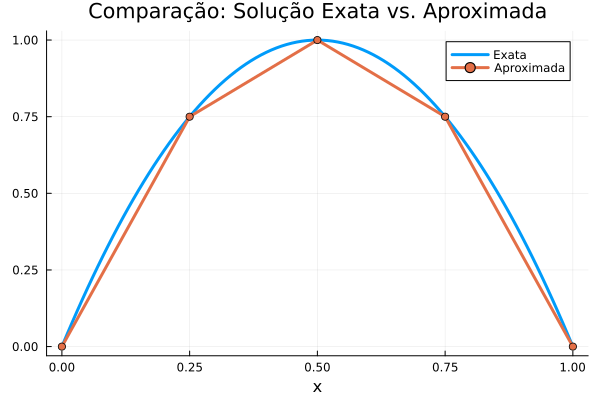

In [10]:
# Carrega o exemplo escolhido
exemplo = 3
α, β, f, u = dados_de_entrada(exemplo)

# Define o número de elementos em que o domínio [0,1] é dividido
ne = 4

# Define a matriz LG
LG = monta_LG(ne)

# Define a dimensão do espaço aproximado Vₘ e o vetor EQ
m, EQ = monta_EQ(ne)

# Define a matriz EQoLG
EQoLG = EQ[LG]

# Exibe os valores ne, LG, m, EQ e EQoLG
display("ne = "); display(ne)
display("LG = "); display(LG)
display("m = "); display(m)
display("EQ = "); display(EQ)
display("EQoLG = "); display(EQoLG)

# Constrói a matriz K e o vetor F
K = monta_K(α, β, ne, m, EQoLG)
F = monta_F(f, ne, m, EQoLG)

# Exibe a matriz K (sistema linear) e o vetor F (vetor força)
display("Matriz K:")
display(K)
display("Vetor F:")
display(F)

# Resolve o sistema linear K * c = F para obter os coeficientes solução aproximada u_h(x)
c = K \ F
display("Solução aproximada U:")
display(c)

# Exibe a solução exata nos nos internos da malha
display("Solução exata nos nós internos:")
h = 1.0 / ne  # Comprimento de cada elemento finito
display(u.(h:h:1-h))

# Calcula o erro entre a solução exata e a solução aproximada
erro = erro_norma_L2(u, [c;0], ne, EQoLG)
display("Erro L²:")
display(erro)

# Define a discretização da malha com N nós internos, incluindo os pontos de fronteira
malha = 0:h:1

# Gera o gráfico comparando a solução aproximada com a solução exata
plt = plot(0:0.01:1, u.(0:0.01:1), label="Exata", lw=3, title="Comparação: Solução Exata vs. Aproximada")
plot!(plt, malha, [0; c; 0], label="Aproximada", lw=3, linestyle=:solid, markershape=:circle) # O "!" adiciona ao gráfico existente
xlabel!("x")  # Adiciona o rótulo ao eixo x

# Exibe o gráfico final
display(plt)

# Estudo da convergência do erro

In [11]:
function estudo_do_erro(exemplo::Int)
    # Carrega os parâmetros e funções do exemplo escolhido
    α, β, f, u = dados_de_entrada(exemplo)

    # Define os valores de ne a serem considerados (de 2^2 a 2^17)
    vec_ne = [2^i for i = 2:17]

    # Inicializa o vetor para armazenar os erros
    vec_erros = zeros(length(vec_ne))

    # Calcula o erro para cada valor de ne
    for i = 1:length(vec_ne)
        # Define o número de elementos em que o domínio [0,1] é dividido
        ne = vec_ne[i]
        # Define a matriz LG
        LG = monta_LG(ne)
        # Define a dimensão do espaço aproximado Vₘ e o vetor EQ
        m, EQ = monta_EQ(ne)
        # Define a matriz EQoLG
        EQoLG = EQ[LG]
        # Constrói a matriz K e o vetor F
        K = monta_K(α, β, ne, m, EQoLG)
        F = monta_F(f, ne, m, EQoLG)
        # Resolve o sistema - option 1
        c = K \ F
        # Calcula o erro
        vec_erros[i] = erro_norma_L2(u, [c;0], ne, EQoLG)
    end
    
    # Calcula o comprimento de cada elemento finito para cada ne
    vec_h = 1.0 ./ vec_ne 

    # Cria o gráfico do erro em função de h em escala logarítmica
    plt = plot(
        vec_h, vec_erros, lw=3, linestyle=:solid, markershape=:circle, 
        label="Erro", title="Estudo do erro - exemplo $exemplo",
        xscale=:log10, yscale=:log10, legend=:topleft
    )
    
    # Adiciona a curva teórica de h² ao gráfico
    plot!(plt, vec_h, vec_h.^2, lw=3, linestyle=:solid, label="h²")
    
    # Adiciona rótulos aos eixos
    xlabel!("h")
    ylabel!("Erro")
    
    # Exibe o gráfico
    display(plt)
    
    # Exibe a tabela com os valores de h e erro
    display("Tabela com os valores de h e erro - exemplo "*string(exemplo))
    display(DataFrame(h=vec_h, erro=vec_erros))
end

estudo_do_erro (generic function with 1 method)

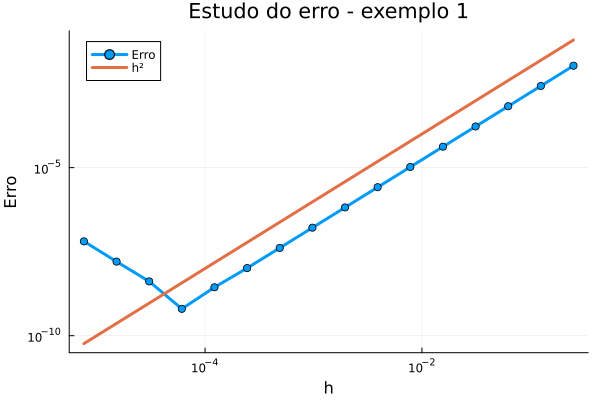

"Tabela com os valores de h e erro - exemplo 1"

Row,h,erro
,Float64,Float64
1,0.25,0.010743
2,0.125,0.00267787
3,0.0625,0.000668977
4,0.03125,0.000167214
5,0.015625,4.18015e-5
6,0.0078125,1.04503e-5
7,0.00390625,2.61256e-6
8,0.00195312,6.53138e-7
9,0.000976562,1.63288e-7


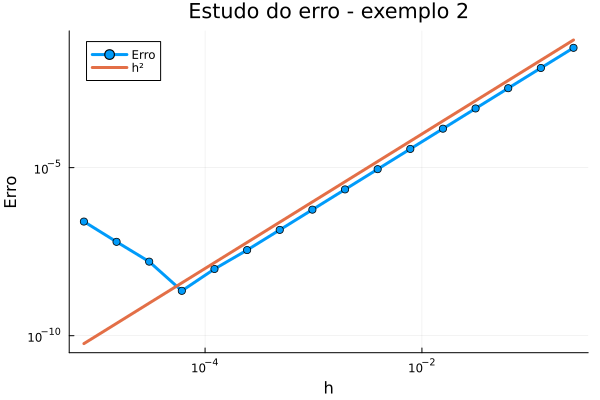

"Tabela com os valores de h e erro - exemplo 2"

Row,h,erro
,Float64,Float64
1,0.25,0.0365421
2,0.125,0.00918215
3,0.0625,0.00229843
4,0.03125,0.000574787
5,0.015625,0.000143708
6,0.0078125,3.59277e-5
7,0.00390625,8.98196e-6
8,0.00195312,2.24549e-6
9,0.000976562,5.61387e-7


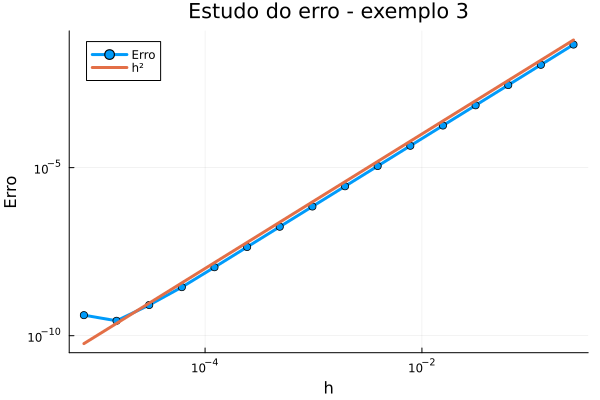

"Tabela com os valores de h e erro - exemplo 3"

Row,h,erro
,Float64,Float64
1,0.25,0.0456435
2,0.125,0.0114109
3,0.0625,0.00285272
4,0.03125,0.00071318
5,0.015625,0.000178295
6,0.0078125,4.45738e-5
7,0.00390625,1.11434e-5
8,0.00195312,2.78586e-6
9,0.000976562,6.96465e-7


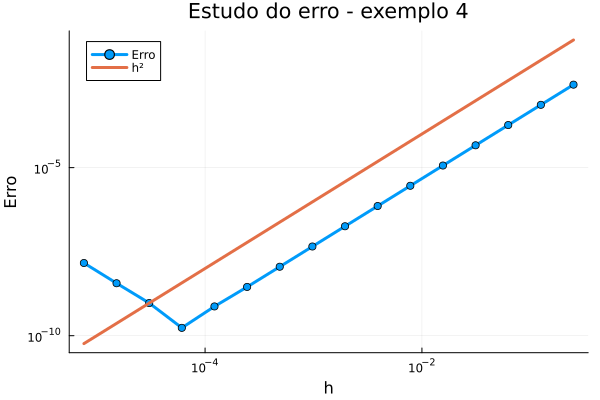

"Tabela com os valores de h e erro - exemplo 4"

Row,h,erro
,Float64,Float64
1,0.25,0.00292992
2,0.125,0.000736338
3,0.0625,0.000184325
4,0.03125,4.60964e-5
5,0.015625,1.1525e-5
6,0.0078125,2.88132e-6
7,0.00390625,7.20334e-7
8,0.00195312,1.80084e-7
9,0.000976562,4.50215e-8


 16.239259 seconds (6.09 M allocations: 989.485 MiB, 1.74% gc time, 7.25% compilation time: 3% of which was recompilation)


In [12]:
@time begin 
    estudo_do_erro(1)
    estudo_do_erro(2)
    estudo_do_erro(3)
    estudo_do_erro(4)
end